In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sqlalchemy import create_engine
import time
from datetime import date, timedelta

engine = create_engine('postgresql://michaelbecker@localhost:5432/spotdb')

In [2]:
c = engine.connect()

In [6]:
#Change zone when running a new model

sql_str = "SELECT date_time, price FROM all_spot WHERE zone LIKE 'us-_' AND type='c3.2xlarge' AND os='Linux/UNIX (Amazon VPC)';"
print sql_str

SELECT date_time, price FROM all_spot WHERE zone LIKE 'us-_' AND type='c3.2xlarge' AND os='Linux/UNIX (Amazon VPC)';


In [7]:
###RETURNING AN EMPTY DATAFRAME... NOT SURE WHY

df = pd.read_sql(sql_str, c)

In [8]:
print df.head()
print df.dtypes

Empty DataFrame
Columns: [date_time, price]
Index: []
date_time    object
price        object
dtype: object


In [48]:
#Change 'date_time' to a datetime type
df['date_time'] = df['date_time'].apply(lambda x: pd.to_datetime(x))

In [49]:
print df.head()
print df.dtypes
print df.shape

            date_time   price
0 2015-07-01 06:09:11  0.0673
1 2015-07-01 06:14:05  0.0676
2 2015-07-01 06:24:09  0.0670
3 2015-07-01 06:34:08  0.0669
4 2015-07-01 06:39:00  0.0667
date_time    datetime64[ns]
price               float64
dtype: object
(235484, 2)


In [50]:
#Make 'date_time' the index
df = df.set_index('date_time')

In [51]:
df.index

DatetimeIndex(['2015-07-01 06:09:11', '2015-07-01 06:14:05',
               '2015-07-01 06:24:09', '2015-07-01 06:34:08',
               '2015-07-01 06:39:00', '2015-07-01 06:43:53',
               '2015-07-01 06:48:55', '2015-07-01 07:13:40',
               '2015-07-01 07:28:35', '2015-07-01 07:33:30',
               ...
               '2017-02-11 23:35:02', '2017-02-11 23:37:02',
               '2017-02-11 23:39:42', '2017-02-11 23:41:56',
               '2017-02-11 23:45:02', '2017-02-11 23:48:17',
               '2017-02-11 23:49:08', '2017-02-12 00:01:05',
               '2017-02-12 00:08:02', '2017-02-12 00:24:44'],
              dtype='datetime64[ns]', name=u'date_time', length=235484, freq=None)

In [52]:
#Make sure the index is sorted apporpriately
df = df.sort_index()

In [53]:
df.index.is_monotonic_increasing

True

In [54]:
print df.head()

                     price
date_time                 
2013-11-14 16:48:58  0.203
2013-11-14 16:48:58  0.203
2013-11-14 16:48:58  0.128
2013-11-14 17:53:48  0.203
2013-11-15 00:43:19  0.128


In [63]:
#We have duplicate values at some prices so need to take the avg fo them before resampling
prod = df.groupby([df.index]).mean()

print prod.head()

                     price
date_time                 
2013-11-14 16:48:58  0.178
2013-11-14 17:53:48  0.203
2013-11-15 00:43:19  0.128
2013-11-15 05:33:34  0.250
2013-11-15 07:18:36  0.203


In [66]:
#resample method = performs a frequency conversion of time series data, resampling it to constant intervals
#pad method = forward fills the data to the next change
#http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
prod = prod.resample('W').pad()

In [67]:
prod.price.describe()


count    170.000000
mean       0.112769
std        0.196429
min        0.064100
25%        0.067625
50%        0.072717
75%        0.097575
max        2.400000
Name: price, dtype: float64

In [68]:
prod.price.head()


date_time
2013-11-17    0.260
2013-11-24    0.128
2013-12-01    0.159
2013-12-08    0.250
2013-12-15    0.203
Freq: W-SUN, Name: price, dtype: float64

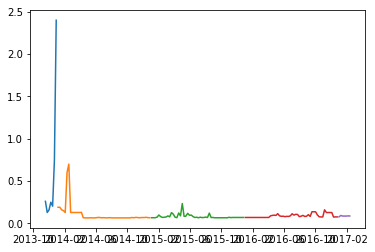

In [69]:
###Graph of prices taking the weekly mean... still no visual of non-stationarity


print plt.plot(prod.price['2013'])
print plt.plot(prod.price['2014'])
print plt.plot(prod.price['2015'])
print plt.plot(prod.price['2016'])
print plt.plot(prod.price['2017'])
#There appears to have no trend but large spikes suggesting an MA model would be most effective
#Additionally, there appears to be a right skew in the price distribution given the large spikes with flat lines between
#Take square root of the prices to negate the spikes (right skew)
#Also, there might be some seasonality with spikes after/around 1st quarter of year and more so at mid year
#shrink down to find trends

In [70]:
#Started with 5 minute resampling but there was zero relationships to be seen
#The weekly data is the shortest period when we start seeing a measurable relationship
#Moving forward with the weekldata for this specific availibility zone

data = prod
train = data.price[:'2016-11-29']
test = data.price['2016-11-30':]

In [71]:
print data.shape
print train.shape
print test.shape

(170, 1)
(159,)
(11,)


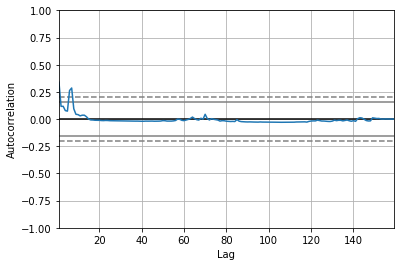

In [72]:
pd.tools.plotting.autocorrelation_plot(train)


In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Figure(432x288)


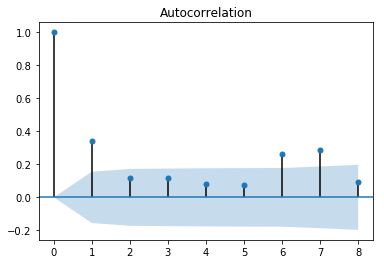

In [74]:
print plot_acf(train, lags=8)
#Helps determine 'p'

Figure(432x288)


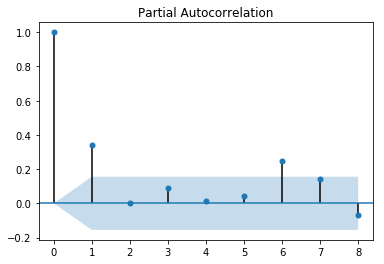

In [75]:
print plot_pacf(train, lags=8)
#helps determine 'q'

In [110]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, (1, 0, 0)).fit()
#us_west_2b order = 4,0,2 
#us_west_2a order = 3,0,0
#us_west_2c order = 4,0,2
#us_west_2* order = 1,0,0

In [111]:
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  159
Model:                     ARMA(1, 0)   Log Likelihood                  38.138
Method:                       css-mle   S.D. of innovations              0.190
Date:                Wed, 03 May 2017   AIC                            -70.277
Time:                        15:02:09   BIC                            -61.070
Sample:                    11-17-2013   HQIC                           -66.538
                         - 11-27-2016                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           0.1151      0.023      5.060      0.000         0.070     0.160
ar.L1.price     0.3385      0.074      4.550      0.000         0.193     0.484
                                    Roots       

Figure(432x288)


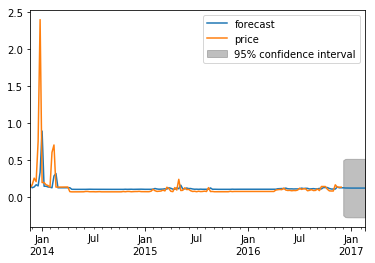

In [109]:

figure = model.plot_predict(1, 170)
print figure

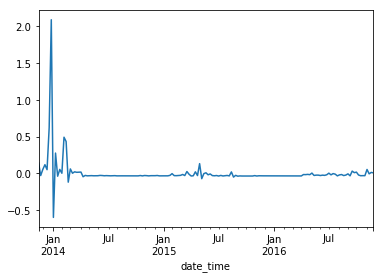

In [105]:
model.resid.plot()

Figure(432x288)
Figure(432x288)


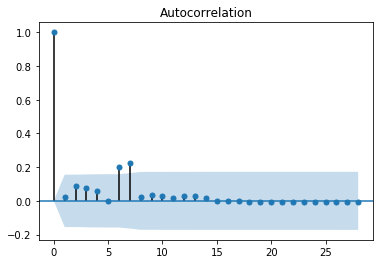

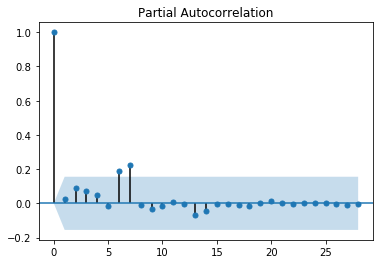

In [106]:

print plot_acf(model.resid, lags=28)
#Decays to zero and hugs the line, suggesting residuals are not correlated
print plot_pacf(model.resid, lags=28)

In [231]:
forecast = model.forecast(steps=7)

In [233]:
print forecast[0]

[ 0.10716565  0.10701309  0.10646618  0.1065319   0.10614924  0.10632059
  0.10600893]


In [245]:
predict = model.predict(start=154, end=161)

In [246]:
print predict

2016-10-30    0.088068
2016-11-06    0.087523
2016-11-13    0.128637
2016-11-20    0.113306
2016-11-27    0.107515
2016-12-04    0.107166
2016-12-11    0.107013
2016-12-18    0.106466
Freq: W-SUN, dtype: float64


In [247]:
train[-5:]

date_time
2016-10-30    0.0757
2016-11-06    0.1597
2016-11-13    0.1082
2016-11-20    0.1082
2016-11-27    0.1082
Freq: W-SUN, Name: price, dtype: float64

In [248]:
test[0:7]

date_time
2016-12-04    0.1082
2016-12-11    0.0732
2016-12-18    0.0762
2016-12-25    0.0762
2017-01-01    0.0762
2017-01-08    0.0914
2017-01-15    0.0861
Freq: W-SUN, Name: price, dtype: float64

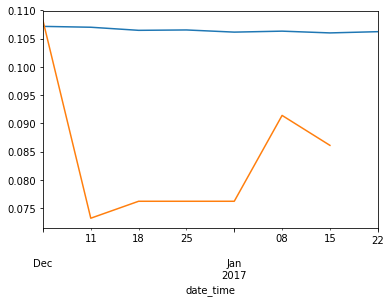

In [244]:
predict.plot()
test[0:7].plot()